simulations of force rate, Kinarm EOM, point to point. 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



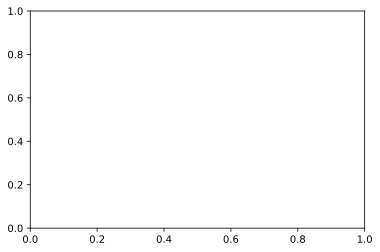

In [1]:
#%% Loop across distances and valuations to generate double-pendulum distance/time predictions. 
import ReachingModels as reaching
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import sys
import plotpresentlib as pp
sys.path.insert(0,'parameterFiles')
import colour as clr 

# model that has equations to compute endpoint jacobians, equations of motion, and energy. 
sim = reaching.Kinarm()
sim.l2 = 0.45


xy_start = np.array([0.0,0.45])
y_amp = np.array([0.05, 0.08, 0.12, 0.17, 0.23])
k=3.5
N_nodes = 20
# time_s = k*y_amp ** (7/8)
time_s = k*y_amp ** (2/3)
bpm = time_s * 60 
freqs = 1/(time_s) 

color1 = clr.Color("#e0f3db")
M = time_s.shape[0]
distcolors = list(color1.range_to(clr.Color("#084081"),M))

duration  = np.zeros(M)
J         = np.zeros(M)
costJFR    = np.zeros(M)
costJWork  = np.zeros(M)
costJTime  = np.zeros(M)
peakspeed = np.zeros(M)

trajList = list()
for i in range(0,M):
  prevOpti = sim.movementTimeOptSetup(
    theTimeValuation  = 1.0,
    theN              = N_nodes, 
    thediscreteOrCont='discrete',
    theDuration = time_s[i])
  
  xy_end = xy_start + np.array([0,y_amp[i]])
  
  qcheck  = sim.xy2joints(xy_start)
  
  trajResult, solOpti = sim.updateGuessAndSolve(
    prevOpti,
    xy_start,
    xy_end,
    theFRCoef=8.5e-2,
    theGeneratePlots=0)
    
    #unpack the results
  duration[i] = trajResult.duration
  J[i]        = trajResult.costJ
  costJFR[i]   = trajResult.costFR
  costJWork[i] = trajResult.costWork
  peakspeed[i] = trajResult.peakspeed
  trajList.append(trajResult)



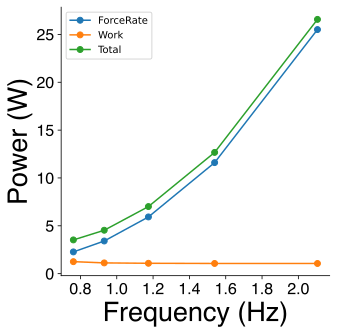

In [2]:
wattsFR = costJFR / duration
wattsWork = costJWork / duration
wattsTotal = (costJFR+costJWork) / duration

f,ax = plt.subplots()
ax.plot(freqs,wattsFR,marker='o')
ax.plot(freqs,wattsWork,marker='o')
ax.plot(freqs,wattsTotal,marker='o')
pp.boxoff()
pp.figurefyTalk()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (W)')
ax.legend(['ForceRate','Work','Total'])



In [32]:
metronome = 1/time_s * 60.
# reps5min as the number of reps in 5 minutes for each time_s
condition_time_s = 5 * 60
reps5min = condition_time_s / time_s
reps5minHalfDuty = 5 * 60 / (time_s * 2)
movements_per_block = 2
num_durations_per_block = movements_per_block*2 # we have a pause between each movement.
blockReps = reps5minHalfDuty/movements_per_block
print("Parameters for experiments! ")

print("The frequencies in Hz are: "+str(np.round(freqs,2))+"Hz.")
print("The amplitudes are: "+str(np.round(y_amp*100,3))+" cm.")
print("The number of blocks for a 5 minute session is: "+str(np.round(blockReps))+".")
print("The metronome should be set at: "+str(np.round(metronome))+" bpm.")

print('Below, check that the block duration in seconds is equal to our condition time of: '+str(condition_time_s)+" s.")
print('  = duration-per-movement * num_durations_per_block * blocks')
print(time_s*blockReps*num_durations_per_block)
print("Note: to regenerate this relation we need k, where t = k*amp^(2/3). Here k = ",k)

Parameters for experiments! 
The frequencies in Hz are: [2.11 1.54 1.17 0.93 0.76]Hz.
The amplitudes are: [ 5.  8. 12. 17. 23.] cm.
The number of blocks for a 5 minute session is: [158. 115.  88.  70.  57.].
The metronome should be set at: [126.  92.  70.  56.  46.] bpm.
Below, check that the block duration in seconds is equal to our condition time of: 300 s.
  = duration-per-movement * num_durations_per_block * blocks
[300. 300. 300. 300. 300.]
Note: to regenerate this relation we need k, where t = k*amp^(2/3). Here k =  3.5


In [4]:
plt.figure(figsize=(10, 6))
energy=list()
for i, traj in enumerate(trajList):
  traj.Q
  energy.append(sim.energy(traj.Q, traj.QDot, traj.U, traj.time))
  plt.plot(traj.time, traj.vecspeed)
  plt.xlabel('Time')
  plt.ylabel('Hand Speed')
  # plt.title(f'Trajectory {i+1}')

  #for comparion, plot a cosine function with amp equal to peakspeed, and freq equal to freqs[i]
  t = np.linspace(0, traj.time[-1], 100)
  plt.plot(t, 1/2*peakspeed[i] - 1/2*peakspeed[i]*np.cos(2*np.pi*freqs[i]*t), '--', color=distcolors[i].hex)

plt.tight_layout()
plt.show()


In [5]:
fig, ax  = plt.subplots(1,2, figsize=(10, 6))
[plt.plot(energy[i].e_joint) for i in range(len(energy))]

[[<matplotlib.lines.Line2D at 0x7fb368767ee0>],

In [6]:
energy[1].e_joint

array([ 0.00000000e+00,  5.51660381e-06,  3.08952920e-04,  2.79212338e-03,
        1.24313529e-02,  3.61599811e-02,  7.27426088e-02,  1.11431212e-01,
        1.42552579e-01,  1.60046443e-01,  1.60599131e-01,  1.43691109e-01,
        1.11667731e-01,  6.98216755e-02,  2.78750425e-02, -1.04358206e-03,
       -1.36167231e-02, -1.71998914e-02, -1.77235645e-02, -1.77349527e-02,
       -1.77349527e-02])

In [7]:
y_amp

array([0.05, 0.08, 0.12, 0.17, 0.23])

In [8]:
y_amp

array([0.05, 0.08, 0.12, 0.17, 0.23])

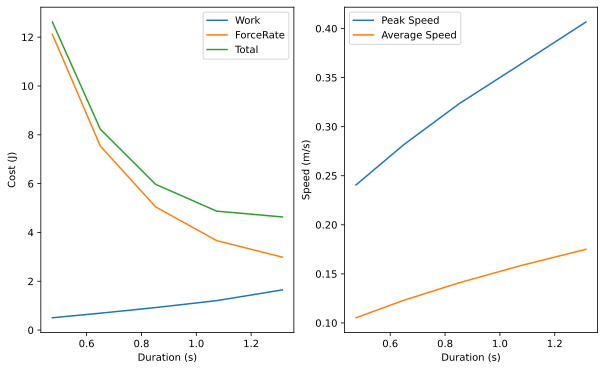

In [9]:
fig, ax  = plt.subplots(1,2, figsize=(10, 6))
ax[0].plot(duration, costJWork)
ax[0].plot(duration, costJFR)
ax[0].plot(duration, costJWork + costJFR)
ax[0].set_xlabel('Duration (s)')
ax[0].set_ylabel('Cost (J)')
ax[0].legend(['Work','ForceRate','Total'])
# on the second subplot, plot average speed and peak speed
ax[1].plot(duration, peakspeed)
# plot average speed as y_amp / duration
ax[1].plot(duration, y_amp / duration)
ax[1].set_xlabel('Duration (s)')
ax[1].set_ylabel('Speed (m/s)')
ax[1].legend(['Peak Speed','Average Speed'])
